In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
import neuron
from neuron import h
import numba
import time, os
import subprocess
import pickle, glob
import scipy.signal
from scipy.signal import find_peaks
import copy
from neuron_help_functions import Cell, calc_cell_section_and_segment_coordinates
from neuron_help_functions import placeCellSection_ByPhiNormalOrigin
from neuron_help_functions import CellPt3dchange_ByPhiNormalOrigin_NEURON

In [2]:
# change cell_id (16 ~ 20 for L5 PCs)
cell_id = 17
data_dir = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data'
cell = Cell(cell_id)

	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
*---------*
Loaded Blue Brain cell 17: L5_TTPC2_cADpyr232_2 
Temperature = 37 C
Applying 90° x-rotation
Got main axon (2)
Myelinating axon: Replacing 96 Axonal sections w/ 171 Myelin, 171 Node, 23 Unmyelin sections
Adding myelin before the 1st bifurcation
Model now has 247 sections and 1240 compartments


In [3]:
section_coords, segment_coords = calc_cell_section_and_segment_coordinates(cell.allSections)
data = {'section_coords': section_coords, 'segment_coords': segment_coords}
save_name = '%s_coordinates_sectionAndSegment.npy' % cell.cell_clone_name
save_path = os.path.join(data_dir, save_name)
print(save_path)
if not os.path.exists(save_path):
    np.save(save_path, data)

C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\L5PC_Clone4_coordinates_sectionAndSegment.npy


Text(0, 0.5, 'z-axis (μm)')

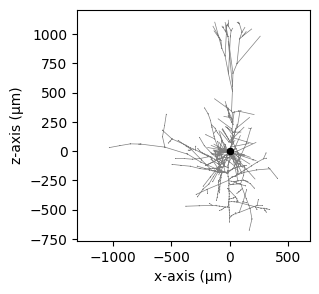

In [4]:
'''Plot cell morphology on the basis of its section coordinates'''
data_name = '%s_coordinates_sectionAndSegment.npy' % cell.cell_clone_name
data_path = os.path.join(data_dir, save_name)
data      = np.load(data_path, allow_pickle=True).item()
section_coords                 = data['section_coords']
cell_section_names             = section_coords['cell_section_names']
cell_section_coordinates_start = section_coords['cell_section_coordinates_start']
cell_section_coordinates_end   = section_coords['cell_section_coordinates_end']
num_section      = len(cell_section_names)
plot_coordinates = np.full((3, 3*num_section), np.nan)
for i in range(num_section):
    plot_coordinates[:, i*3] = cell_section_coordinates_start[i, :]
    plot_coordinates[:, i*3+1] = cell_section_coordinates_end[i, :]
# plot cell morphology
fig = plt.figure(figsize=(3, 3))
ax  = fig.add_subplot(111)
ax.plot(plot_coordinates[0], plot_coordinates[2], color='gray', lw=0.5, zorder=-1) # x-z plane
soma_center = cell.get_section_center(cell.allSections[0])
ax.scatter(soma_center[0], soma_center[2], s=20, color='k', zorder=0)
ax.axis('equal')
# ax.axis('off')
ax.set_xlabel('x-axis (μm)', fontsize=10)
ax.set_ylabel('z-axis (μm)', fontsize=10)

In [5]:
%%time
# (1) Load cell section coordinates
data_name = '%s_coordinates_sectionAndSegment.npy' % cell.cell_clone_name
data_path = os.path.join(data_dir, save_name)
cellData  = np.load(data_path, allow_pickle=True).item()
print('cellData keys: ', cellData.keys())
'''section coordinates'''
section_coords = cellData['section_coords']
cell_section_names             = section_coords['cell_section_names']
cell_section_coordinates_start = section_coords['cell_section_coordinates_start'] * 1e-3 # unit: μm → mm
cell_section_coordinates_end   = section_coords['cell_section_coordinates_end'] * 1e-3   # unit: μm → mm
cell_section_coordinates_mid   = section_coords['cell_section_coordinates_mid'] * 1e-3   # unit: μm → mm
num_section                    = len(cell_section_names)
'''segment coordinates'''
segment_coords = cellData['segment_coords']
cell_segment_names             = segment_coords['cell_segment_names']
cell_segment_coordinates_start = segment_coords['cell_segment_coordinates_start'] * 1e-3 # unit: μm → mm
cell_segment_coordinates_end   = segment_coords['cell_segment_coordinates_end'] * 1e-3   # unit: μm → mm
cell_segment_coordinates_mid   = segment_coords['cell_segment_coordinates_mid'] * 1e-3   # unit: μm → mm
num_segment                    = len(cell_segment_names)

# (2) Load mesh information of L5 surface of interest (L5 SOI) after downsampling
dataPath = os.path.join(data_dir, 'Layer5_information_after_downsampling.npy')
surfData = np.load(dataPath, allow_pickle=True).item()
print('surfData keys: ', surfData.keys())
cell_normals = surfData['cell_normals']
cell_origins = surfData['cell_origins'] # unit is mm
num_element  = surfData['num_elem']

# (3) Rotate cell section and segment coordinates by element normal, and then shift by element center
# Note that we do not initialize azimuthal orientation, i.e., phi, randomly for each cell
'''section'''
popCells_section_coords   = {}
section_coordinates_start = np.zeros((num_element, num_section, 3))
section_coordinates_end   = np.zeros((num_element, num_section, 3))
section_coordinates_mid   = np.zeros((num_element, num_section, 3))
for i in range(num_element):
    cell_normal = cell_normals[i, :]
    cell_origin = cell_origins[i, :]
    secCoordStart, secCoordEnd, secCoordMid = placeCellSection_ByPhiNormalOrigin(cell_section_coordinates_start, cell_section_coordinates_end, \
                                 cell_section_coordinates_mid, cell_phi=None, cell_normal=cell_normal, cell_origin=cell_origin)
    section_coordinates_start[i, :, :] = secCoordStart
    section_coordinates_end[i, :, :]   = secCoordEnd
    section_coordinates_mid[i, :, :]   = secCoordMid
popCells_section_coords['section_coordinates_start'] = section_coordinates_start
popCells_section_coords['section_coordinates_end']   = section_coordinates_end
popCells_section_coords['section_coordinates_mid']   = section_coordinates_mid
'''segment'''
popCells_segment_coords   = {}
segment_coordinates_start = np.zeros((num_element, num_segment, 3))
segment_coordinates_end   = np.zeros((num_element, num_segment, 3))
segment_coordinates_mid   = np.zeros((num_element, num_segment, 3))
for i in range(num_element):
    cell_normal = cell_normals[i, :]
    cell_origin = cell_origins[i, :]
    segCoordStart, segCoordEnd, segCoordMid = placeCellSection_ByPhiNormalOrigin(cell_segment_coordinates_start, cell_segment_coordinates_end, \
                                 cell_segment_coordinates_mid, cell_phi=None, cell_normal=cell_normal, cell_origin=cell_origin)
    segment_coordinates_start[i, :, :] = segCoordStart
    segment_coordinates_end[i, :, :]   = segCoordEnd
    segment_coordinates_mid[i, :, :]   = segCoordMid
popCells_segment_coords['segment_coordinates_start'] = segment_coordinates_start
popCells_segment_coords['segment_coordinates_end']   = segment_coordinates_end
popCells_segment_coords['segment_coordinates_mid']   = segment_coordinates_mid

# (4) Save the section and segment coordinates for each cell in the layer population: including start, mid, and end points
data = {
    'popCells_section_coords': popCells_section_coords,
    'popCells_segment_coords': popCells_segment_coords,
    'cell_normals': cell_normals,
    'cell_origins': cell_origins
}

save_name = '%s_popCell_sectionAndSegmentCoordinates.npy' % cell.cell_clone_name
save_path = os.path.join(data_dir, save_name)
print(save_path)
if not os.path.exists(save_path):
    np.save(save_path, data)

cellData keys:  dict_keys(['section_coords', 'segment_coords'])
surfData keys:  dict_keys(['surface', 'vnormals', 'cell_normals', 'cell_origins', 'depth', 'num_elem'])
C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\L5PC_Clone4_popCell_sectionAndSegmentCoordinates.npy
Wall time: 15.2 s
